In [1]:
import pandas as pd

from bokeh.io import output_notebook, show
from bokeh.plotting import figure

import numpy as np
from scipy import signal

output_notebook()

%matplotlib inline


# filter design
def filter_trace(s, dt=0.01, lowcut=0.1, highcut=10.0, order=2):
    fs=1/dt
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.lfilter(b, a, s-np.median(s))


Loading BokehJS ...

In [2]:
# in the first tests the samplig was not homogeneous



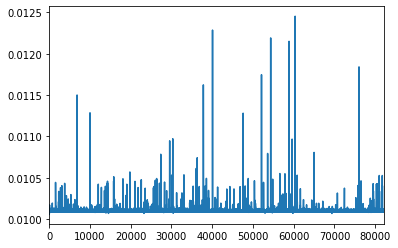

In [23]:
df = pd.read_csv('check_time_03.txt', sep=' ', names=['t', 'x', 'y', 'z'])
n = df.t.diff().plot()

dt = 0.01

## scale signals
df.x *= 2/(2**20)
df.y *= 2/(2**20)
df.z *= 2/(2**20)

df.x -= np.median(df.x)
df.y -= np.median(df.y)
df.z -= np.median(df.z)

new_timestamps = np.arange(df.t.min(), df.t.max(), dt)
x = np.interp(new_timestamps, df.t, df.x) 
y = np.interp(new_timestamps, df.t, df.y)
z = np.interp(new_timestamps, df.t, df.z)

x_ = filter_trace(x, lowcut=0.01, highcut=5.0, order=4)
y_ = filter_trace(y, lowcut=0.01, highcut=5.0, order=4)
z_ = filter_trace(z, lowcut=0.01, highcut=5.0, order=4)

In [33]:
sel = z
new_t = new_timestamps - df.t.min()

mask = np.logical_and( (new_t > 7), (new_t < 15) )
sel_wave = sel[mask]
new_t_wave = new_t[mask]

mask =  new_t < 5 # noise
sel_noise = sel[mask]
new_t_noise = new_t[mask]

p = figure(plot_width=1000, plot_height=300) #, x_range=(0, 28)  ,  y_range=(-.02, .02)) # driller
#p = figure(plot_width=1000, plot_height=300 , x_range=(0, 14),  y_range=(-.02, .02))
p.line(new_t, sel, line_width=2, line_color='blue', legend='all')
p.line(new_t_wave, sel_wave, line_width=2, line_color='green', legend='wave')
p.line(new_t_noise, sel_noise, line_width=2, line_color='red', legend='noise')
p.xaxis.axis_label = 'Time (s)'
p.yaxis.axis_label = 'Acceleration (g)'
show(p)

f, Pxx = signal.welch(sel, 1/dt, nperseg=256, scaling="spectrum")
f_noise, Pxx_noise = signal.welch(sel_noise, 1/dt, nperseg=256, scaling="spectrum")
f_wave, Pxx_wave = signal.welch(sel_wave, 1/dt, nperseg=256, scaling="spectrum")

p = figure(plot_width=400, plot_height=400, y_axis_type="log", x_axis_type="log")
p.line(f, Pxx/len(new_t), line_width=2, line_color='blue', legend='all')
p.line(f_wave, Pxx_wave/len(new_t_wave), line_width=2, line_color='green', legend='wave')
p.line(f_noise, Pxx_noise/len(new_t_noise), line_width=2, line_color='red', legend='noise')
p.legend.location = 'bottom_left'
p.xaxis.axis_label = 'Frequency (hz)'
p.yaxis.axis_label = 'Power acceleration density (g^2/Hz)'
show(p)

### 

In [4]:
from obspy.core.trace import Trace
s_000 = Trace(x, header={'delta':dt})
s_000.write('test_time_02.sac', type='SAC')